In [2]:
import math 
import numpy as np
import pandas as pd
import sympy
from matplotlib import pyplot as plt
from tabulate import tabulate

In [3]:
def plot_fun(f, a, b, label="", color="r", step=0.01, ax=plt, title="Wykres funkcji"):
    n = int((b-a)/step)+1
    x = np.linspace(a,b,n)[1:]
    ax.plot(x, [f(xi) for xi in x], color=color, label=label)
    if label:
        ax.legend(loc="best")

    if ax is plt:
        ax.title(title)
        ax.xlabel("x")
        ax.ylabel("y")
    else:
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
    ax.grid()

In [4]:
def abs_diff(F,f, x):
    return [abs(F(xi)-float(f(xi))) for xi in x]

def max_diff(F,f, x):
    return max(abs_diff(F,f, x))

def mean_square_error(F,f, x):
    return sum(d ** 2 for d in abs_diff(F,f, x))

def calculate_error(F, f, a, b, N=1000):
    x = np.linspace(a,b,N)
    diffs = abs_diff(F,f,x)
    return {
        "max": max(diffs),
        "sq": sum(x**2 for x in diffs)
    }

def error(F, f, a, b, N=1000):
    err = calculate_error(F,f,a,b,N)
    print(tabulate([
        ("Bezwzgledny blad", err["max"]),
        ("Suma kwadratów róznic", err["sq"])
    ]))

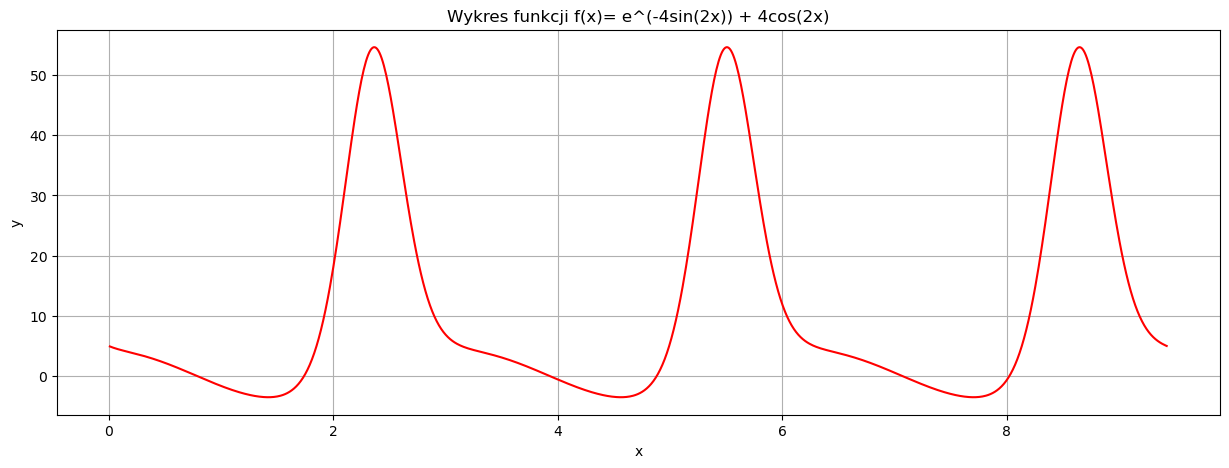

In [5]:
f = lambda x, k, m: math.e**(-k*math.sin(m*x)) + k*math.cos(m*x) 

g = lambda x: f(x, 4, 2)
a = 0
b = 3*math.pi
plt.figure(figsize=(15,5))
plot_fun(g, a, b, title="Wykres funkcji f(x)= e^(-4sin(2x)) + 4cos(2x)") 
plt.show()

In [6]:
def least_square_approximation(x, y, weights, degree):
    X = np.vander(x, degree + 1, increasing=True)
    
    W = np.diag(np.sqrt(weights))
    X_weighted = W @ X
    y_weighted = W @ y
    
    coefficients = np.linalg.lstsq(X_weighted, y_weighted, rcond=None)[0]
    
    y_pred = X @ coefficients
    
    mse = np.mean((y - y_pred) ** 2)
    
    return coefficients, mse

In [7]:
def aproximation_func(x, y, n, deg, w):
    coefficients, mse = least_square_approximation(x, y, w, deg)

    def poly_func(x):
        return sum(coef * x**i for i, coef in enumerate(coefficients))

    return poly_func

def plot_aprox(n, deg, show_err=False):
    x = np.linspace(a,b,n)
    y = [g(xi) for xi in x]
    w = np.ones_like(x)
    F = aproximation_func(x,y,n,deg,w)

    if show_err:
        error(F, g, a,b)

    fig, ax = plt.subplots(1, figsize=(15,4))
    plot_fun(g,a,b,color="blue",ax=ax,label="funkcja bazowa")
    plot_fun(F,a,b,color="red",ax=ax, label="aproksymacja", title=f"Aproksymacja dla {n} węzłów i {deg} stopni")
    ax.scatter(x,y, color="black")
    plt.show()


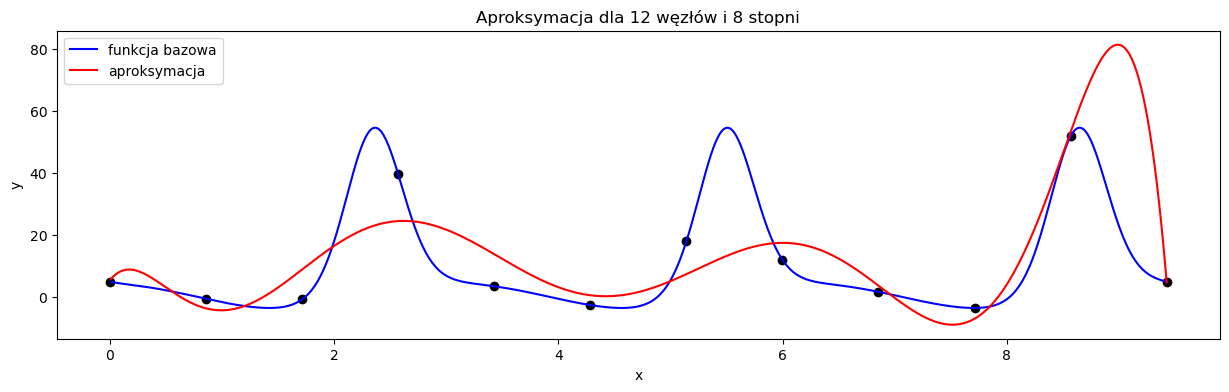

In [8]:
plot_aprox(12,8)

In [9]:
def approximation_test(n, m):
    for mi in m:
        plot_aprox(n, mi, show_err=True)

#approximation_test(10, range(2,20))
    
def find_best_aprox(F, a, b, n, deg):
    abs_matirx = np.zeros((len(n), len(deg)))
    sq_matrix = np.zeros((len(n), len(deg)))

    for ni in n:
        x = np.linspace(a,b,ni)
        y = np.vectorize(F)(x)
        for d in deg:
            if d > ni:
                break
            f = aproximation_func(x,y,ni, d, np.ones_like(x))
            err = calculate_error(g,f,a,b)
            abs_matirx[ni-n[0], d-deg[0]] = err["max"]
            sq_matrix[ni-n[0], d-deg[0]] = err["sq"]
    return abs_matirx, sq_matrix

def find_min_error(mat):
    err = np.inf
    idx_i, idx_j = -1, -1
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            if mat[i,j] != 0 and mat[i,j] < err:
                err = mat[i,j]
                idx_i, idx_j = i, j
    return err, idx_i, idx_j

In [10]:
n = range(3,200)
deg = range(3,50)

ab, sq = find_best_aprox(g,a,b,n,deg)

In [11]:
# table for sum square error 
df = pd.DataFrame(sq)
df.iloc[[10,20,30,40,50,100,150]].loc[:, [2,3,5,10,15]]

,2,3,5,10,15
10,297276.244419,298936.934488,297512.916027,3.046560e+06,0.000000
20,282859.874634,281716.667297,168309.654693,8.842170e+04,321212.083925
30,281919.671969,280959.829899,162601.601781,8.157922e+04,216076.333145
40,281420.110984,280552.060113,159036.434661,8.092163e+04,211776.276503
50,281117.428420,280299.375119,156734.396452,8.071252e+04,211173.043914
100,280575.342767,279833.405557,152320.570017,8.028063e+04,210422.933383
150,280443.972482,279716.848248,151184.114559,9.203578e+04,210092.197677


In [12]:
df = pd.DataFrame(ab)
df.iloc[[10,20,30,40,50,100,150]].loc[:, [2,3,5,10,15]]

,2,3,5,10,15
10,46.115043,44.437705,64.860577,276.888308,0.000000
20,46.684897,45.922618,36.100791,26.780089,75.248034
30,46.519143,45.854003,36.037301,26.301094,55.194174
40,46.391076,45.772433,35.857399,26.084656,55.099413
50,46.302411,45.715103,35.706141,26.000210,55.068869
100,46.089817,45.575945,35.296906,25.945204,55.056880
150,46.005999,45.520849,35.126196,26.965147,55.066640


(23.186970751136357, 15, 10)
(79825.05772517207, 98, 11)


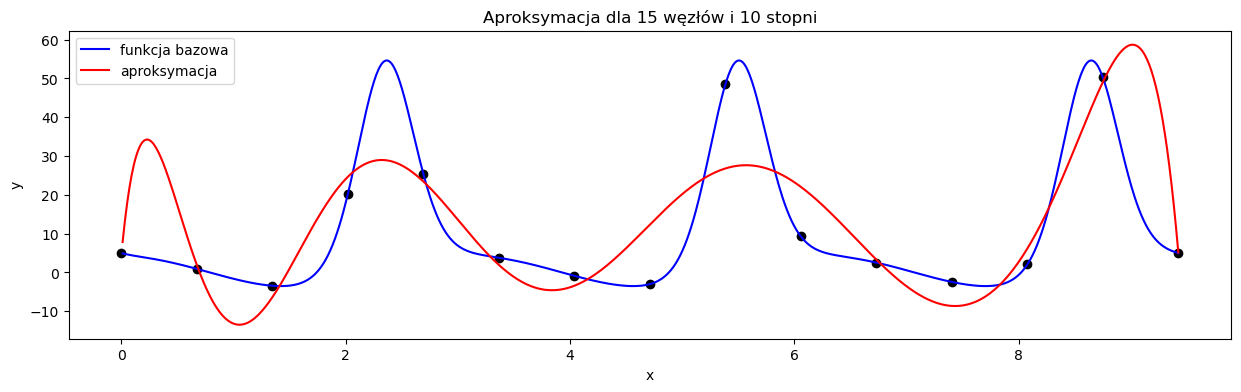

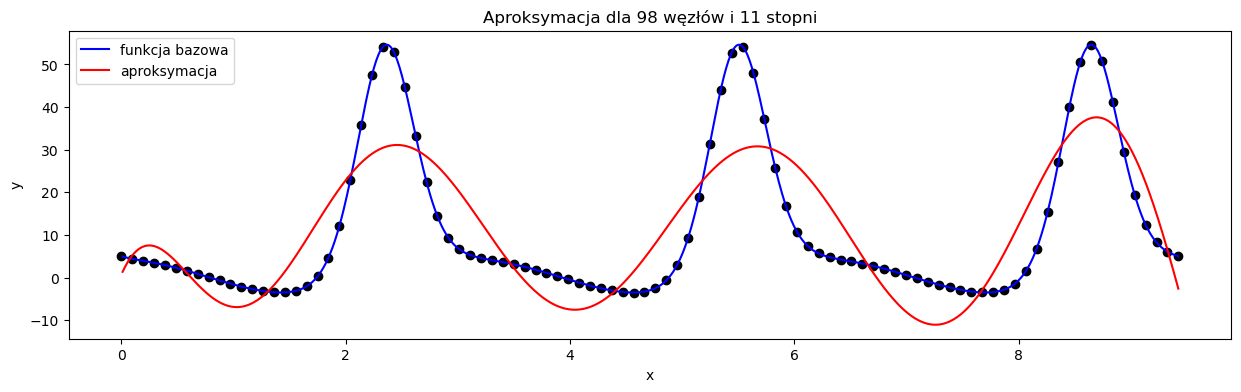

In [13]:
best_abs = find_min_error(ab)
best_sq = find_min_error(sq)
print(best_abs)
print(best_sq)
plot_aprox(15,10)
plot_aprox(98,11)

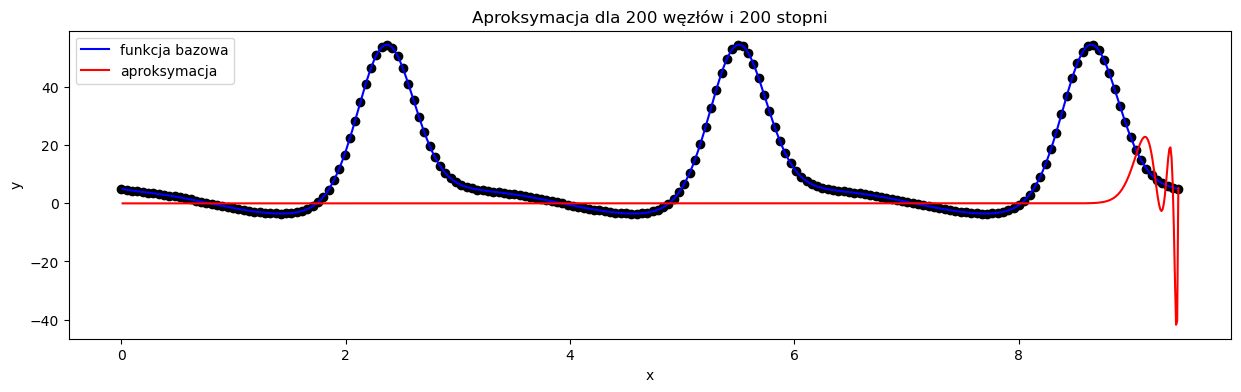

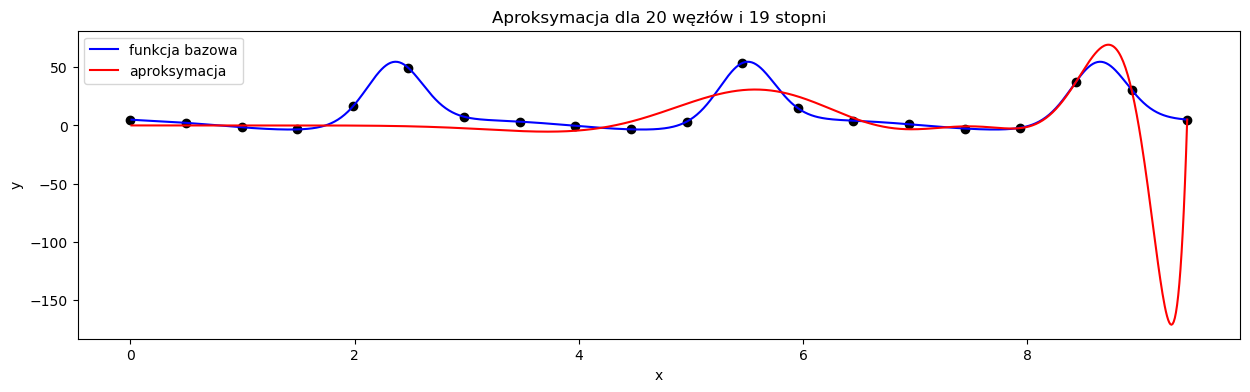

In [14]:
plot_aprox(200,200)
plot_aprox(20,19)